Online property companies offer valuations of houses using machine learning techniques. 
The dataset consisted of historic data of houses sold between May 2014 to May 2015.
We will predict the sales of houses in King County with an accuracy of at least 75-80% and understand which factors are responsible for higher property value - $650K and above.”


<b> Problem statement</b>The aim of this report is to predict the house sales in King County, Washington State, USA using different models (Adaboost & GBM)


Dataset: https://www.kaggle.com/shivachandel/kc-house-data

### **STEP 1:   IMPORTING LIBRARIES**

In [3]:
from __future__ import division

import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import explained_variance_score
from time import time
from sklearn.metrics import r2_score
import os
from sklearn.model_selection import train_test_split

#from sklearn import cross_validation, tree, linear_model


In [4]:
data = pd.read_csv('data/kc_house_data.csv')

In [5]:
# Copying data to another dataframe df_train for our convinience so that original dataframe remain intact.

df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)

In [6]:
# Now lets see the first five rows of the data
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### **STEP 2:  DATA CLEANING AND PREPROCESSING**

In [7]:
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types of each column
print(data.dtypes)

21613
21
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [9]:
# Check any number of columns with NaN or missing values 
print(data.isnull().any().sum(), ' / ', len(data.columns))


0  /  21


In [10]:
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21613


### **STEP 3 : FINDING CORRELATION**

In [16]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [17]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [18]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


As zipcode is negatively correlated with sales price , so we can remove it for sales price prediction.

### **STEP 4 : EDA or DATA VISUALIZATION**

Let's explore the data

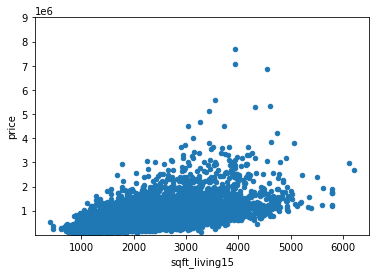

In [11]:
var = 'sqft_living15'
data = pd.concat([data['price'], data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(3,9000000));

(-0.5, 12.5, 0.0, 3500000.0)

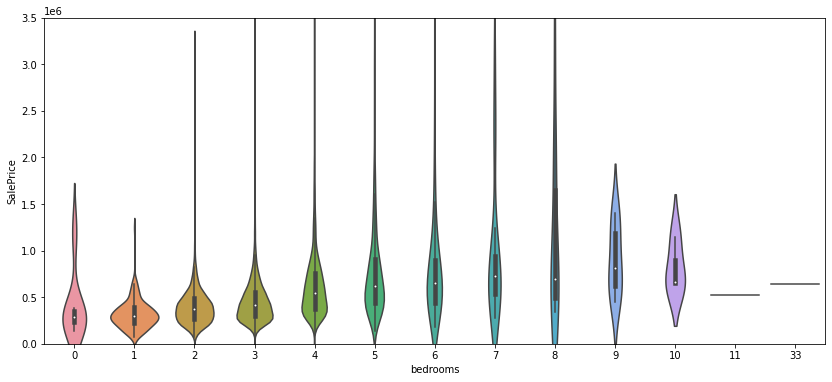

In [13]:
var = 'bedrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000)

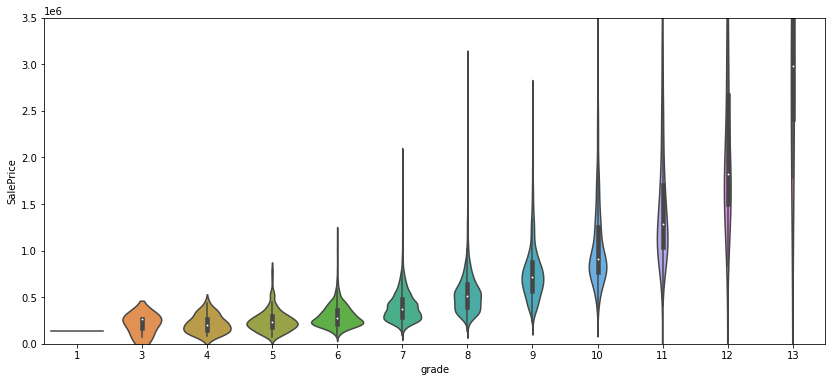

In [14]:
var = 'grade'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

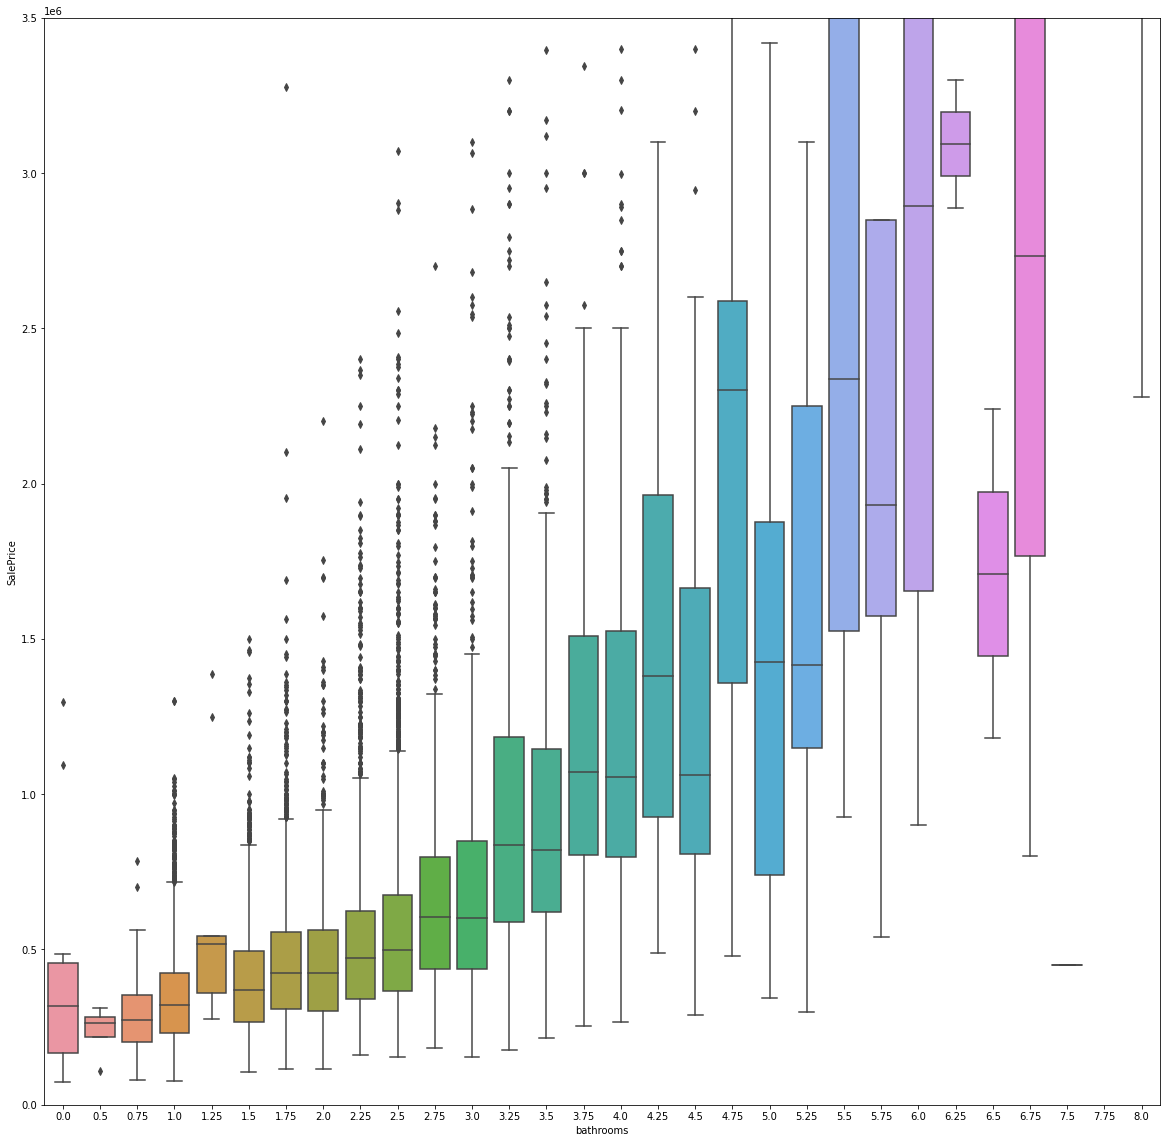

In [15]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

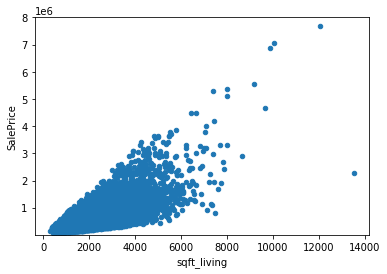

In [16]:
var = 'sqft_living'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(3,8000000));


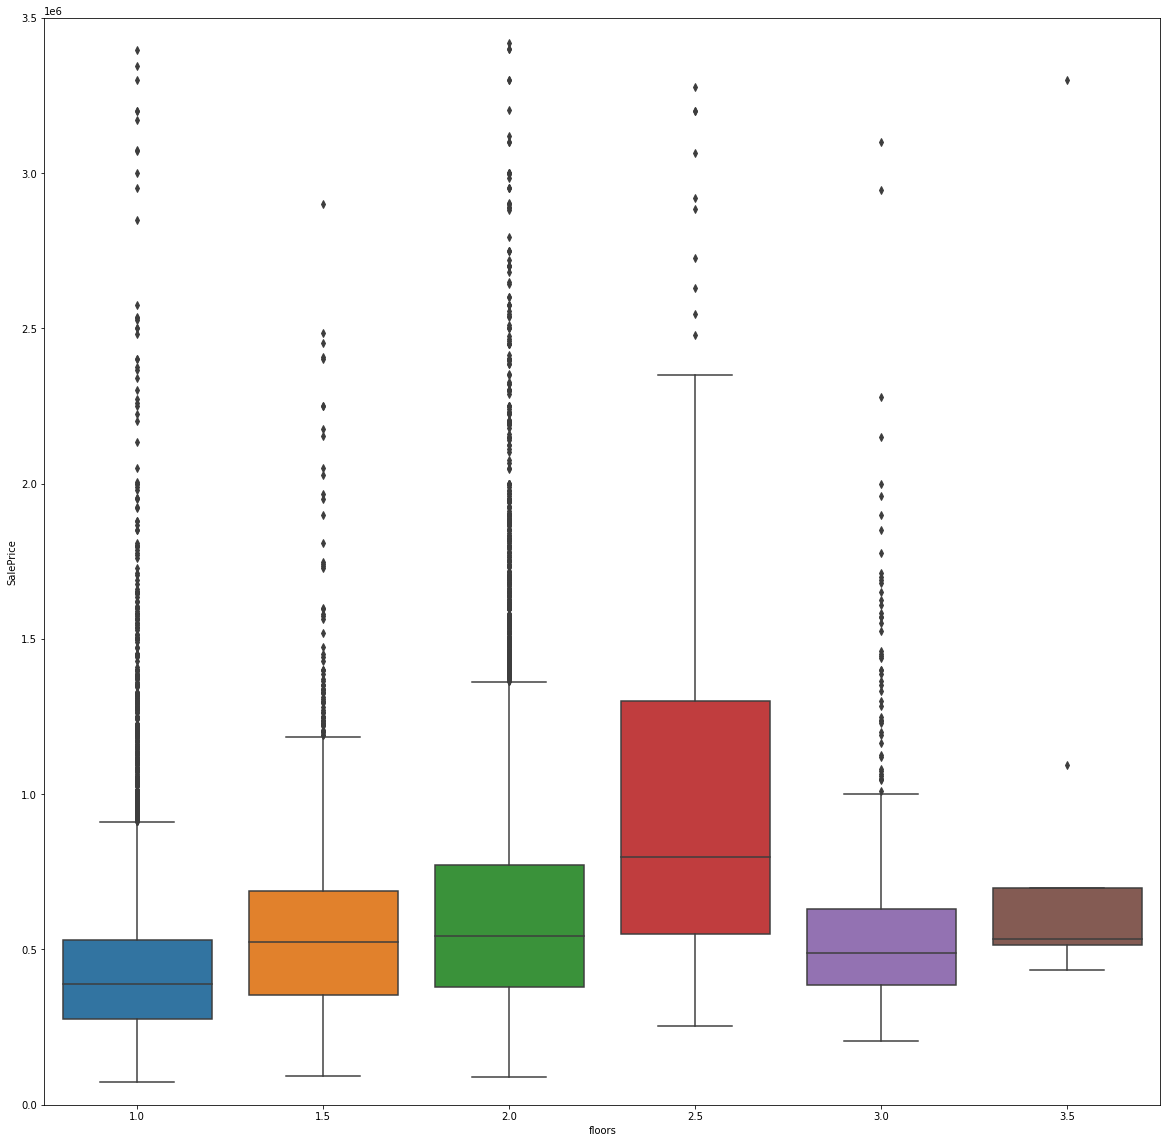

In [17]:
var = 'floors'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

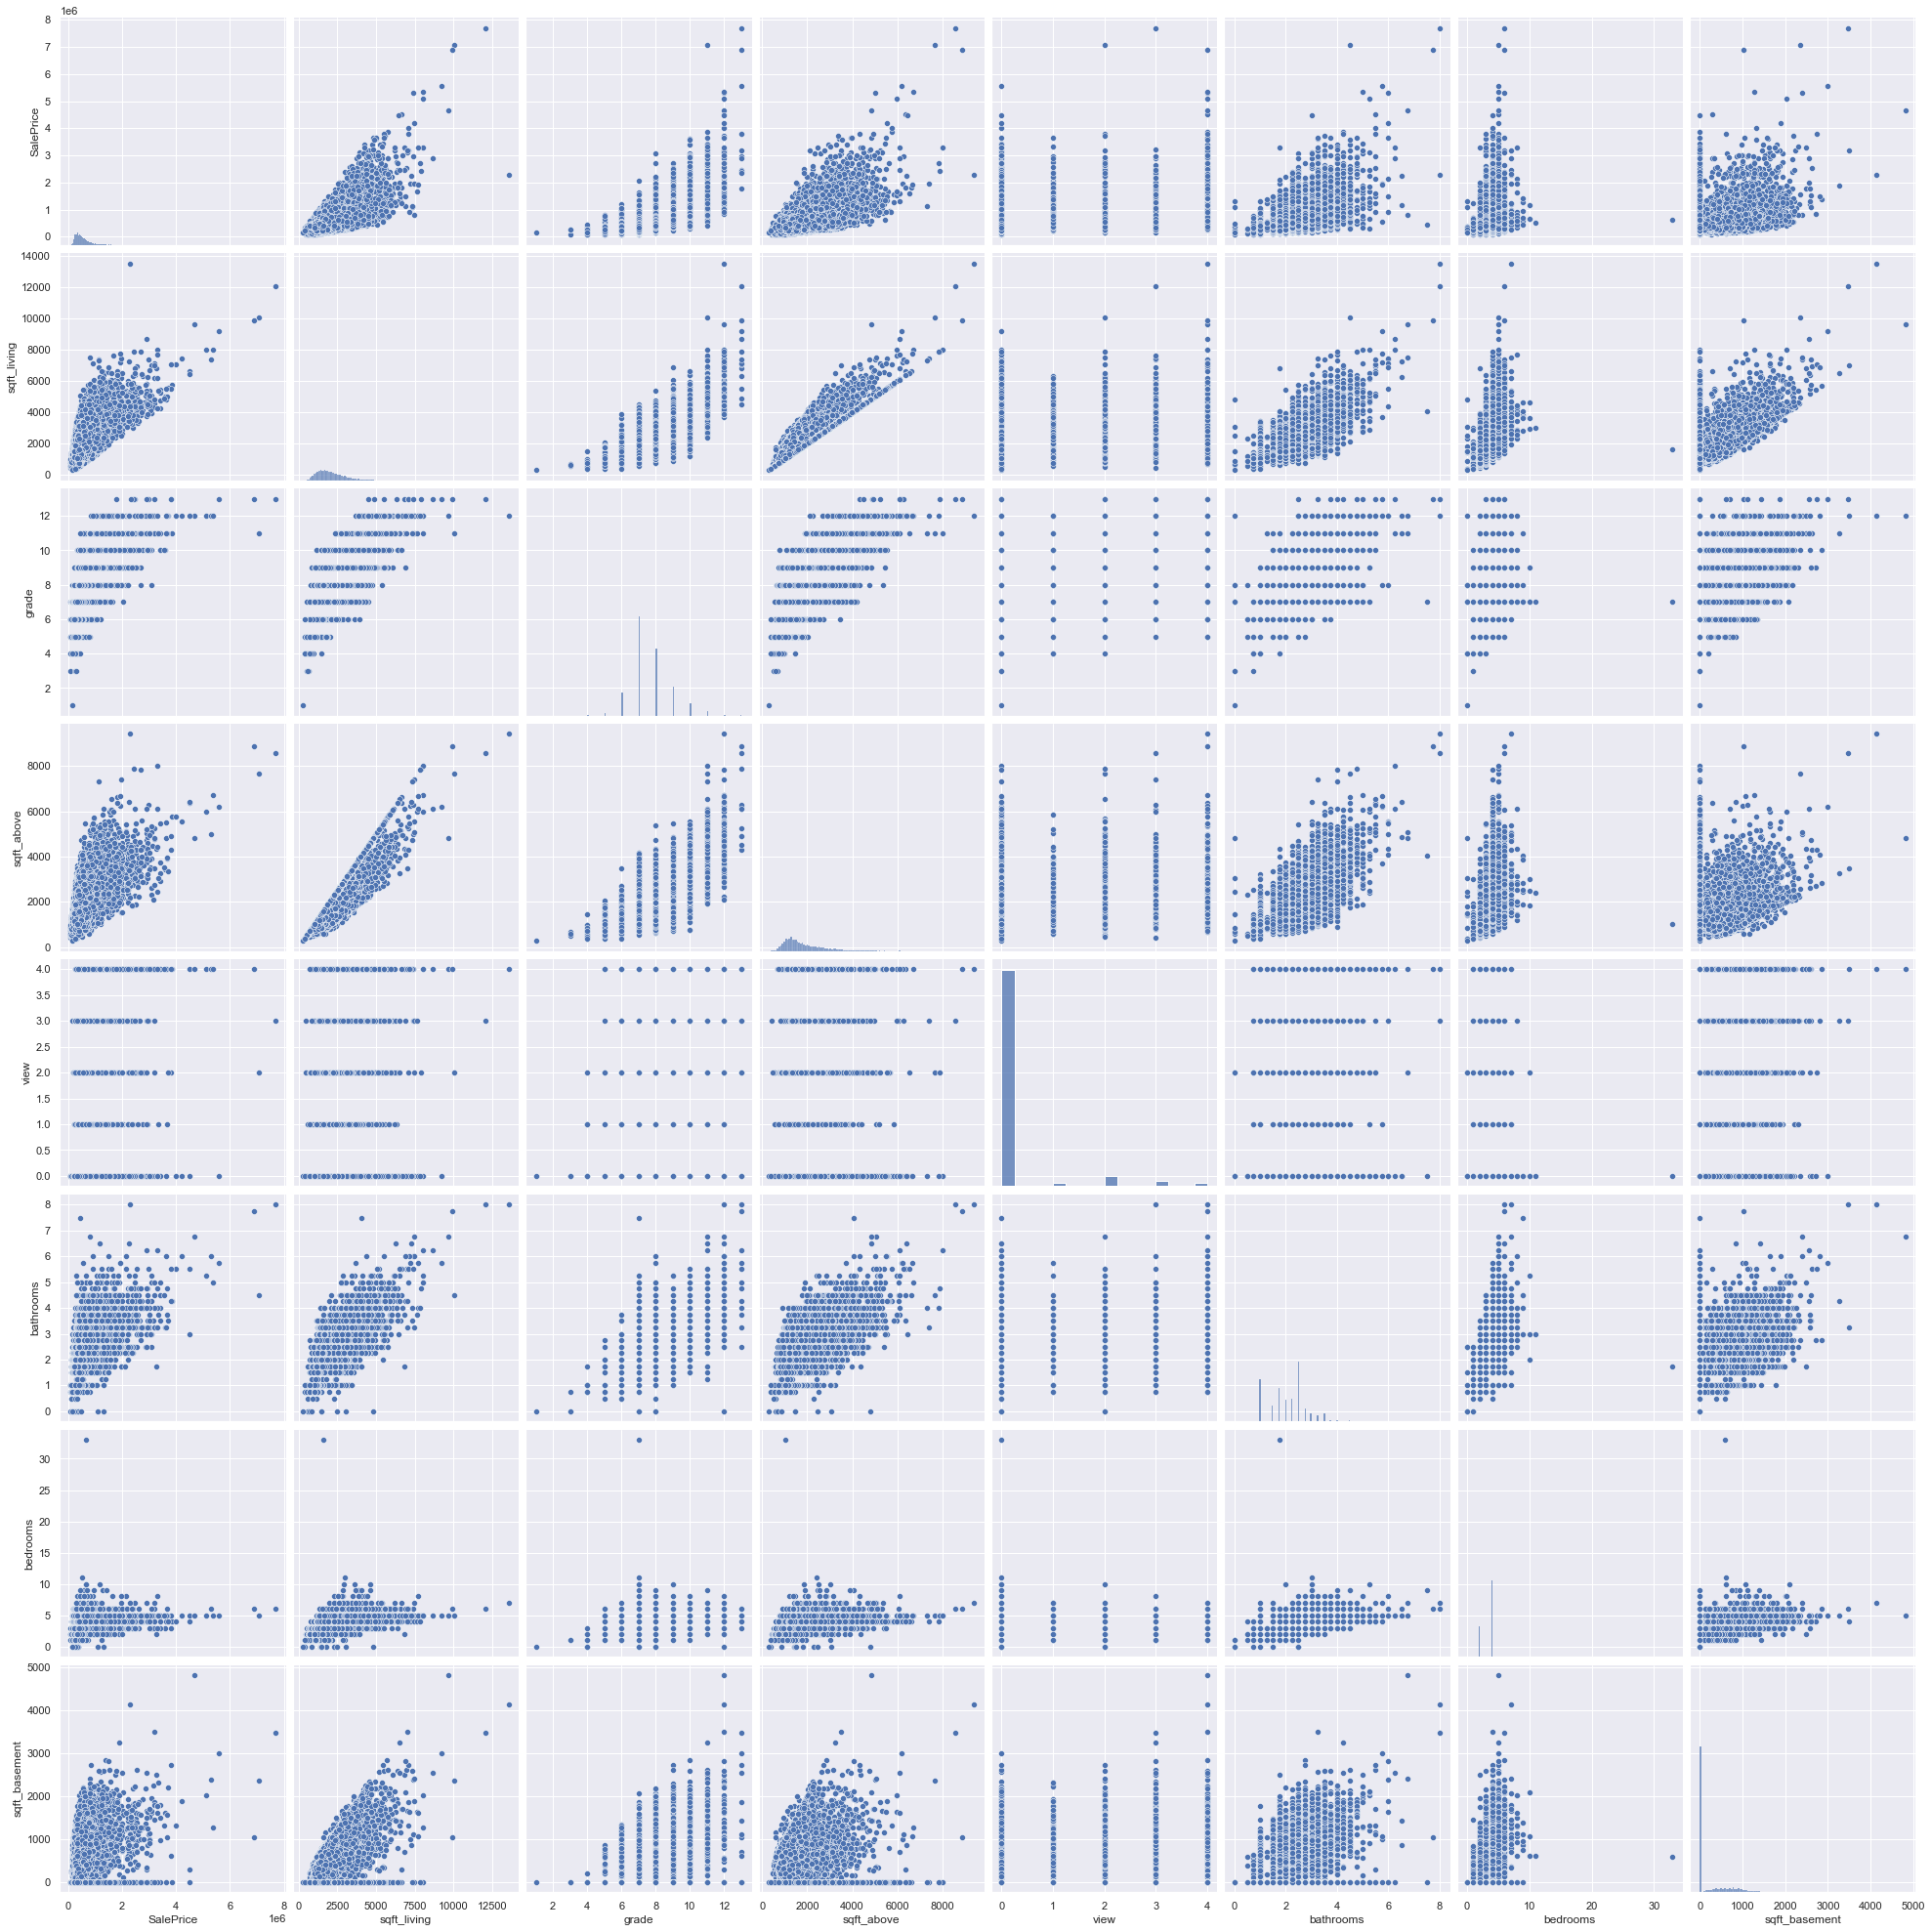

In [18]:
#Pairplots to visualize strong correlation
sns.set()
cols = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms','bedrooms','sqft_basement']
sns.pairplot(df_train[cols], height = 3.5)
plt.show();

In [19]:
filtered_data = df_train[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]

In [20]:
X = filtered_data.values
y = df_train.SalePrice.values

### **STEP 5 : SPLITTING DATA INTO TRAINING AND TESTING SET**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

### **STEP 6: APPLYING MACHINE LEARNING MODEL**

# Adaboost

In [22]:
from sklearn.ensemble import AdaBoostRegressor
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
pred=ada.predict(X_test)
adab=ada.score(X_test,y_test)
predict = ada.predict(X_test)
exp_ada = explained_variance_score(predict,y_test)

# GBM

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
gbm=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(X_train, y_train)
gradient=gbm.score(X_test,y_test)

pred = gbm.predict(X_test)
exp_est = explained_variance_score(pred,y_test)

In [24]:
# Comparing Models on the basis of Model's Accuracy Score and Explained Variance Score of different models
models_cross = pd.DataFrame({
    'Model': ['Gradient Boosting','AdaBoost'],
    'Score': [gradient,adab],
     'Variance Score': [exp_est,exp_ada]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score,Variance Score
0,Gradient Boosting,0.867034,0.852598
1,AdaBoost,0.673551,0.518154
